In [2]:
from briefcase.case import Case
from briefcase.case_base import CaseBase
from briefcase.enums import incons_enum
import import_ipynb
import pandas as pd
import matplotlib.pyplot as plt
import TelcoConverter as TC
import random

historic_splits = [0.25, 0.5, 0.75, 0.95]

def test_constrainted_inconsistency(data_splits, constraint="ALL"):
    historic = data_splits['historic']
    new = data_splits['new']
    
    historic_cases = [Case.from_dict(c) for c in historic]
    cb = CaseBase(historic_cases)
    
    admitted = 0
    for item in new:
        new_case = Case.from_dict(item)
        # test without adding to case base
        if cb.order.admissibility_constraints.is_case_admissible(new_case.reason, new_case.defeated(), constraint):
            admitted += 1
            
    print(f"Number of cases admitted: {admitted}")
    size, inconsistencies = cb.metrics()
    return admitted, size, inconsistencies

def split_data(data):
    data_splits = {}
    for historic_split in historic_splits:
        historic = random.sample(data, k=int(historic_split * len(data)))
        # take 40 samples because max samples when 95% is 45
        new = random.sample(data, k=40)
        data_splits[historic_split] = {'historic': historic, 'new': new}
    return data_splits


In [3]:
# Initial Stats 
data = TC.get_existing_test_data()
initial_cases = [Case.from_dict(c) for c in data]
initial_cb = CaseBase(initial_cases)
initial_cb.metrics()
filtered_1perc_power = TC.filter_data_by_power(data, 1)

Loaded data successfully from 'data/telco-corr-test-0.25-False.yaml'
Number of cases:  1413
Number of cases associated with inconsistency:  927
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10


## Admissibility experiments 
1. Split the data into a set of historic cases, and new cases 
2. Add each 

In [9]:
def experiment_perc_incons(data, repetitions=100):
    # Initialize results list
    results = []
    
    # Repeat the experiment
    for _ in range(repetitions):
        data_splits = split_data(data)
        
        for historic_split in historic_splits:
            for constraint in [incons_enum.NO, incons_enum.NO_NEW, incons_enum.NO_INVOLVEMENT, 
                               incons_enum.HORTY, incons_enum.NO_CORRUPTION, incons_enum.ALL]:
                print(f"\nHistoric Split: {historic_split}")
                print(f"Constraint: {constraint.name}")
                
                # Run the experiment
                admitted, cases_size, tainted_cases = test_constrainted_inconsistency(data_splits[historic_split], constraint=constraint)
                
                # Store the results
                results.append({'Historic Split': historic_split, 
                                'Constraint': constraint.name, 
                                'No. cases admitted': admitted,
                                "No. cases": cases_size,
                                "No. inconsistent cases": tainted_cases,
                                "No. total cases for admission": len(data_splits[historic_split]['new'])})
    
    # Convert results to DataFrame for easier manipulation
    results_df = pd.DataFrame(results)
    
    # Group by Historic Split and Constraint, calculate the average
    average_results = results_df.groupby(['Historic Split', 'Constraint']).mean().reset_index()
    
    plot_all(average_results, repetitions)
    no_new_involvement_no_corruption_plot(average_results, repetitions)
    return average_results

def no_new_involvement_no_corruption_plot(average_results, repetitions):
    # Calculate the percentage of new cases admitted
    average_results['Percentage new cases admitted'] = average_results['No. cases admitted'] / average_results['No. total cases for admission'] * 100
    
    average_results['Constraint'] = average_results['Constraint'].replace('HORTY', 'NO_NEW+NO_INVOLVEMENT')
    
    
    # Filter DataFrame for the constraints (B) and (C)
    filtered_df = average_results[average_results['Constraint'].isin(['NO_NEW+NO_INVOLVEMENT', 'NO_CORRUPTION'])]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    for constraint in filtered_df['Constraint'].unique():
        sub_df = filtered_df[filtered_df['Constraint'] == constraint]
        plt.plot(sub_df['Historic Split'], sub_df['Percentage new cases admitted'], label=constraint)
    
    plt.title(f"Average Percentage of New Cases Admitted with (B) NO_NEW+NO_INVOLVEMENT, and (C) NO_CORRUPTION admissibility constraints ({repetitions} trials)")
    plt.xlabel("Percentage cases in existing case base")
    plt.ylabel("Average percentage of new cases admitted")
    plt.grid(True)
    plt.show()

def plot_all(average_results, repetitions):
    # Plotting
    plt.figure(figsize=(10, 6))
    
    for constraint in average_results['Constraint'].unique():
        sub_df = average_results[average_results['Constraint'] == constraint]
        plt.plot(sub_df['Historic Split'], sub_df['No. cases admitted'], label=constraint)
    
    plt.title(f"Average Number of New Cases Admitted to a Case Base with all Admissibility Constraints - {repetitions} trials")
    plt.xlabel("Percentage cases in existing case base")
    plt.ylabel("Number of new cases admitted")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, None)  # y-axis starts at 0
    plt.show()


Historic Split: 0.25
Constraint: NO
Number of cases admitted: 0
Number of cases:  363
Number of cases associated with inconsistency:  206
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10

Historic Split: 0.25
Constraint: NO_NEW
Number of cases admitted: 30
Number of cases:  363
Number of cases associated with inconsistency:  206
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10

Historic Split: 0.25
Constraint: NO_INVOLVEMENT
Number of cases admitted: 23
Number of cases:  363
Number of cases associated with inconsistency:  206
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10

Historic Split: 0.25
Constraint: HORTY
Number of cases admitted: 38
Number of cases:  363
Number of cases associated with inconsistency:  206
Maximum number of ed

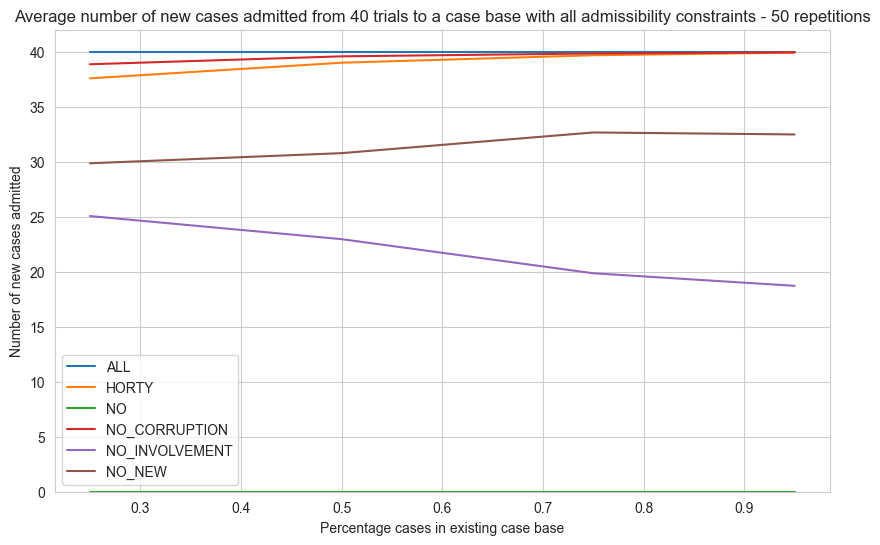

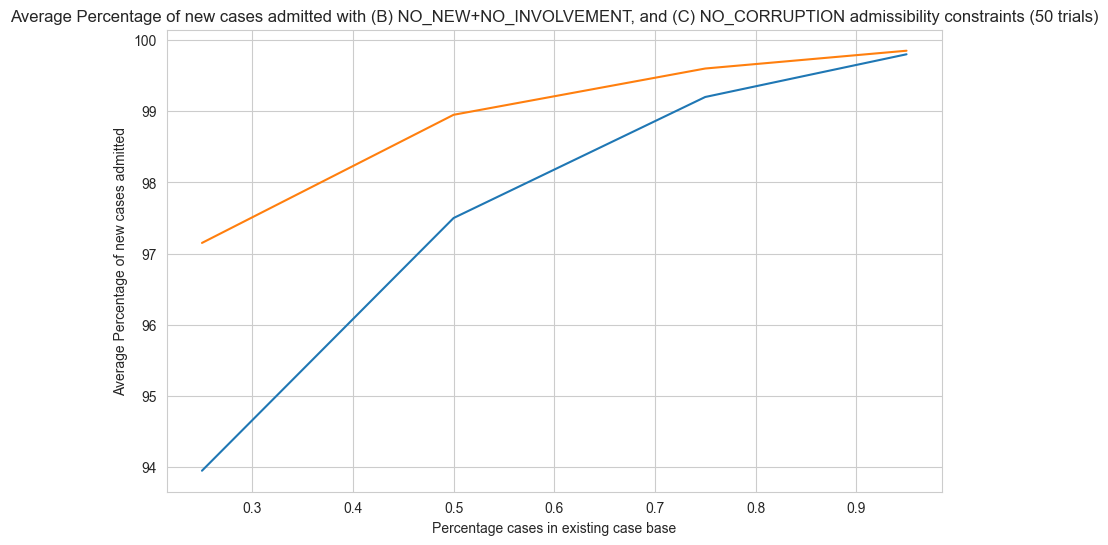

,Historic Split,Constraint,No. cases admitted,No. cases,No. inconsistent cases,No. total cases for admission,Percentage new cases admitted
0,0.25,ALL,40.00,353.98,164.82,40.0,100.00
1,0.25,NO_NEW+NO_INVOLVEMENT,37.58,353.98,164.82,40.0,93.95
2,0.25,NO,0.00,353.98,164.82,40.0,0.00
3,0.25,NO_CORRUPTION,38.86,353.98,164.82,40.0,97.15
4,0.25,NO_INVOLVEMENT,25.06,353.98,164.82,40.0,62.65
5,0.25,NO_NEW,29.86,353.98,164.82,40.0,74.65
6,0.50,ALL,40.00,706.10,394.72,40.0,100.00
7,0.50,NO_NEW+NO_INVOLVEMENT,39.00,706.10,394.72,40.0,97.50
8,0.50,NO,0.00,706.10,394.72,40.0,0.00
9,0.50,NO_CORRUPTION,39.58,706.10,394.72,40.0,98.95


In [10]:
experiment_perc_incons(data, 50)


Historic Split: 0.25
Constraint: NO
Number of cases admitted: 0
Number of cases:  272
Number of cases associated with inconsistency:  17
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10

Historic Split: 0.25
Constraint: NO_NEW
Number of cases admitted: 21
Number of cases:  272
Number of cases associated with inconsistency:  17
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10

Historic Split: 0.25
Constraint: NO_INVOLVEMENT
Number of cases admitted: 40
Number of cases:  272
Number of cases associated with inconsistency:  17
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10

Historic Split: 0.25
Constraint: HORTY
Number of cases admitted: 40
Number of cases:  272
Number of cases associated with inconsistency:  17
Maximum number of edges 

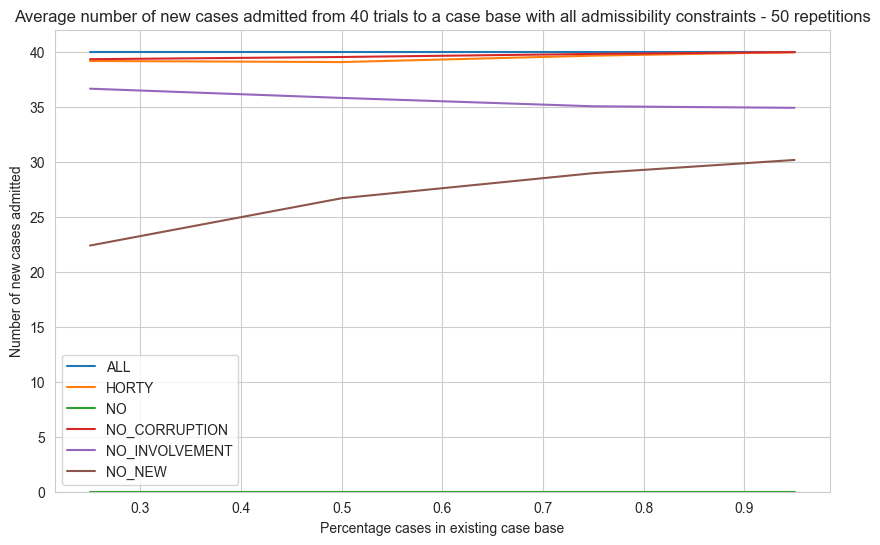

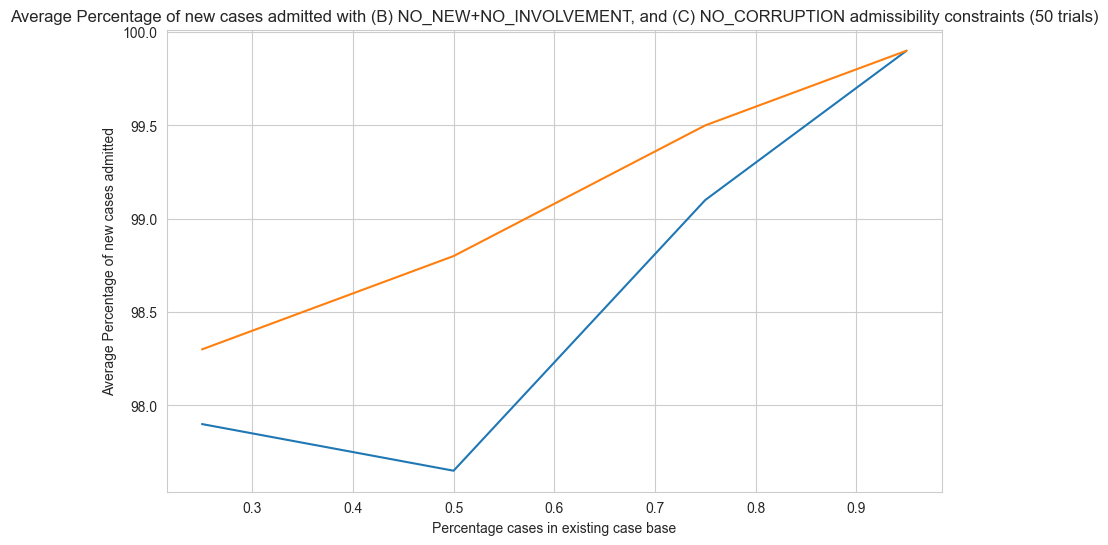

,Historic Split,Constraint,No. cases admitted,No. cases,No. inconsistent cases,No. total cases for admission,Percentage new cases admitted
0,0.25,ALL,40.00,265.78,29.96,40.0,100.00
1,0.25,NO_NEW+NO_INVOLVEMENT,39.16,265.78,29.96,40.0,97.90
2,0.25,NO,0.00,265.78,29.96,40.0,0.00
3,0.25,NO_CORRUPTION,39.32,265.78,29.96,40.0,98.30
4,0.25,NO_INVOLVEMENT,36.64,265.78,29.96,40.0,91.60
5,0.25,NO_NEW,22.38,265.78,29.96,40.0,55.95
6,0.50,ALL,40.00,532.28,72.70,40.0,100.00
7,0.50,NO_NEW+NO_INVOLVEMENT,39.06,532.28,72.70,40.0,97.65
8,0.50,NO,0.00,532.28,72.70,40.0,0.00
9,0.50,NO_CORRUPTION,39.52,532.28,72.70,40.0,98.80


In [12]:
experiment_perc_incons(filtered_1perc_power, 50)
# lower power, any pair of cases smaller circle, more no involvement, less priority order thing

In [ ]:
# 